In [12]:
import numpy as np
import matplotlib.pyplot as plt
import skimage.feature
from tensorflow.keras import datasets, layers, models
import pandas as pd
import geopandas  as gpd 
import os
import torch
from torch.utils.data import Dataset
import zipfile
import pickle
import sentinelhub # this import is necessary for pickle loading
import rasterio as rio
from rasterio import features
from tqdm import tqdm
from PIL import Image
import sys
sys.path.append("..")
from s1dataset import S1Dataset
import sklearn as skl
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.metrics import adjusted_rand_score
from time import time
from matplotlib.colors import ListedColormap
from scipy.ndimage import uniform_filter
from scipy.ndimage import variance
from scipy import signal
from glob import glob

In [2]:
cropLabels = ["Wheat", "Rye", "Barley", "Oats", "Corn", "Oil Seeds", "Root Crops", "Meadows", "Forage Crops"]

In [3]:
trainingLabels =(r'../br-18E-242N-crop-labels-train-2018.geojson')
testingLabels = (r'../br-17E-243N-crop-labels-test-2019.geojson')
mask = np.load(r'../sentinel-1/s1-asc-utm-34S-20E-259N-2017/mask/MASK.npy')
bbox = np.array(pickle.load(open(r"../sentinel-1/s1-asc-utm-34S-20E-259N-2017/bbox.pkl","rb")))
trainingDataDir = (r'..\sentinel-1\s1-asc-utm-33N-18E-242N-2018')
testingDataDir = (r'..\sentinel-1\s1-asc-utm-33N-17E-243N-2019')

In [4]:
##Extracts the timeseries from the files and performs limited preprocessing on the data
def ExtractPolarities(dataPath):
    vv = np.load(os.path.join(dataPath, "data", "VV.npy"))
    vh = np.load(os.path.join(dataPath, "data", "VH.npy"))
    vv[np.isnan(vv)] = 0.001
    vv[np.isinf(vv)] = 0.001
    vv[vv > 1] = 0.001
    vv[vv < 0] = 0.001

    vh[np.isnan(vh)] = 0.001
    vh[np.isinf(vh)] = 0.001
    vh[vh > 1] = 0.001
    vh[vh < 0] = 0.001
    
    filteredVV = vv
    filteredVH = vh
    
    #kernel for basic sharpening filter
    kernel = np.array([[ 0,-1,0],
                   [-1 ,8 ,-1],
                   [ 0,-1,0]])

    for i in tqdm(range(vv.shape[0]), desc="Processing timeseries"):

        
        reshapedVV = filteredVV[i].reshape(2400, 2400)
        reshapedVH = filteredVH[i].reshape(2400, 2400)

        #applies slected filter to each band before  they are stacked
        reshapedVV =frost_filter(reshapedVV,window_size=3, alpha=2)
        reshapedVH = frost_filter(reshapedVH, window_size=3, alpha=2)
        # reshapedVV =boxcar_filter(reshapedVV,size=3)
        # reshapedVH = boxcar_filter(reshapedVH, size=3)
        
        reshapedVV = signal.convolve2d(reshapedVV, kernel, boundary='fill',fillvalue=0, mode = 'same')
        reshapedVH = signal.convolve2d(reshapedVH, kernel, boundary='fill',fillvalue=0, mode = 'same')

        reshapedVV = reshapedVV.reshape(2400, 2400,1)
        reshapedVH = reshapedVH.reshape(2400, 2400,1)
      
        filteredVV[i] = reshapedVV
        filteredVH[i] = reshapedVH

    vv = filteredVV
    vh = filteredVH
    del filteredVV
    del filteredVH
    datatimeDates = np.load(os.path.join(dataPath, "timestamp.pkl"),allow_pickle=True)
    dates = [date.strftime('%Y-%m-%d ') for date in datatimeDates]
    
    bands = np.stack([vv[:,:,:,0],vh[:,:,:,0]], axis=3)
    del vv
    del vh
    bands[np.isnan(bands)] = 0
    bands[np.isinf(bands)] = 0  
    bands[bands > 1] = 0.001
    bands[bands < 0] = 0.001

    for i in range(bands.shape[0]):
        progress_bar = '[' + '=' * i + ']'
        print(f'\rProcessing: {progress_bar} {i}/{bands.shape[0]} ({i / bands.shape[0]:.1%})', end='', flush=True)
        bands[i][:][:][0] = skl.preprocessing.normalize(bands[i][:][:][0])
        bands[i][:][:][1] = skl.preprocessing.normalize(bands[i][:][:][1])  
    return bands, dates

def CreateImage(bands):
    imageFrame = bands[0]
    height = imageFrame.shape[0]
    width = imageFrame.shape[1]
    pixelArray = np.zeros((bands.shape[0],height,width,3),dtype=np.float32)
    
    for i in range(int(bands.shape[0])):
        imageFrame = bands[i]
        progress_bar = '[' + '=' * i + ']'
        print(f'\rProcessing: {progress_bar} {i}/{bands.shape[0]} ({i / bands.shape[0]:.1%})', end='', flush=True)
        
        ##fairly standard sar data to rgb layout of R: VV, G: VH, B: VV-VH
        fact = 2
        # pixelArray[i,:,:,0] =  imageFrame[:,:,0]/(imageFrame[:,:,0].mean()*fact)
        # pixelArray[i,:,:,1] =  imageFrame[:,:,1]/(imageFrame[:,:,1].mean()*fact)
        # pixelArray[i,:,:,2] =  (imageFrame[:,:,0]/(imageFrame[:,:,0].mean()) - 
        #              np.abs(imageFrame[:,:,1])/(np.abs(imageFrame[:,:,1]).mean()))*fact
        
        # For a more visually appealing image
        pixelArray[i,:,:,0] =  np.abs(imageFrame[:,:,0])/(np.abs(imageFrame[:,:,0]).mean()*fact)
        pixelArray[i,:,:,1] =  imageFrame[:,:,1]/(imageFrame[:,:,1].mean()*fact)
        pixelArray[i,:,:,2] =  imageFrame[:,:,0]/(imageFrame[:,:,0].mean()*fact)
    return pixelArray;

def createLabels(zippath,labelgeojson):
    return setup(zippath, labelgeojson)
    print(f"saving extracted time series with label data to {npzcache}")

def boxcar_filter(img, size):
    kernel = np.ones((size,size))
    filtered_img = signal.convolve2d(img, kernel, boundary='fill',fillvalue=0, mode = 'same')
    return filtered_img


def frost_filter(img, window_size, alpha):
    # Calculate local means
    local_mean = signal .convolve2d(img, np.ones((window_size, window_size)) / (window_size**2), mode='same', boundary='symm')
    
    # Calculate local variances
    local_variance = signal .convolve2d(img**2, np.ones((window_size, window_size)) / (window_size**2), mode='same', boundary='symm') - local_mean**2
    
    # Calculate global mean and variance
    global_mean = np.mean(local_mean)
    global_variance = np.mean(local_variance)
    
    # Calculate adaptive weight
    weight = (local_variance + alpha * global_variance) / (local_variance + global_variance)
    
    # Apply Frost filter
    filtered_img = local_mean + weight * (img - local_mean)
    
    return filtered_img

In [5]:
def setup(zippath, labelgeojson):
    """
    This utility function unzipps a dataset from Sinergize and performs a field-wise aggregation.
    results are written to a .npz cache with same name as zippath
    """
    datadir = os.path.dirname(zippath)
    rootpath = zippath.replace(".zip", "")
    if not (os.path.exists(rootpath) and os.path.isdir(rootpath)):
        print(f"unzipping {zippath} to {datadir}")
        with zipfile.ZipFile(zippath, 'r') as zip_ref:
            zip_ref.extractall(datadir)
    else:
        print(f"found folder in {rootpath}, no need to unzip")

    # find all .gz-ipped files and unzip
    for gz in glob(os.path.join(rootpath,"*","*.gz")) + glob(os.path.join(rootpath,"*.gz")):
        print(f"unzipping {gz}")
        gunzip(gz)

    with open(os.path.join(rootpath, "bbox.pkl"), 'rb') as f:
        bbox = pickle.load(f)
        crs = str(bbox.crs)
        minx, miny, maxx, maxy = bbox.min_x, bbox.min_y, bbox.max_x, bbox.max_y

    labels = gpd.read_file(labelgeojson)
    # project to same coordinate reference system (crs) as the imagery
    labels = labels.to_crs(crs)

    vv = np.load(os.path.join(rootpath, "data", "VV.npy"))
    vh = np.load(os.path.join(rootpath, "data", "VH.npy"))
    bands = np.stack([vv[:,:,:,0],vh[:,:,:,0]], axis=3)
    #clp = np.load(os.path.join(rootpath, "data", "CLP.npy"))
    #bands = np.concatenate([bands, clp], axis=-1) # concat cloud probability
    _, width, height, _ = bands.shape

    transform = rio.transform.from_bounds(minx, miny, maxx, maxy, width, height)

    fid_mask = features.rasterize(zip(labels.geometry, labels.fid), all_touched=True,
                              transform=transform, out_shape=(width, height))
    assert len(np.unique(fid_mask)) > 0, f"vectorized fid mask contains no fields. " \
                                         f"Does the label geojson {labelgeojson} cover the region defined by {zippath}?"
    crop_mask = features.rasterize(zip(labels.geometry, labels.crop_id), all_touched=True,
                              transform=transform, out_shape=(width, height))
    assert len(np.unique(crop_mask)) > 0, f"vectorized fid mask contains no fields. " \
                                          f"Does the label geojson {labelgeojson} cover the region defined by {zippath}?"

    fids = []
    crop_ids = []
    tsdata = []
    fe = []
    for fid, crop_id in tqdm(zip(labels.fid.unique(), labels.crop_id.values), total=len(labels), desc="extracting time series"):
        field_mask = fid_mask == fid
        if field_mask.sum() > 0:
            data = bands.transpose(0, 3, 1, 2)[:, :, field_mask].mean(-1)
            tsdata.append(data)
            crop_ids.append(crop_id)
            fids.append(fid)
        else:
            print(f"field {fid} contained no pixels. Is it too small with {labels.loc[labels.fid==fid].geometry.area}m2 ? skipping...")

    tsdata = np.stack(tsdata)
    
    return tsdata, fids, crop_ids,crop_mask, fid_mask

In [6]:

def kmeans_image(image, k, crop_mask):
    # Reshape the image into a 2D array of pixels
    bands = image.shape[-1]
    #pixels = image.reshape(-1, bands)    
    flattened_data = image.reshape(-1, bands)
    print(flattened_data)
    valid_indices = ~np.isnan(flattened_data).any(axis=1)
    # valid_indices = valid_indices[valid_indices !=0]
    
    print(valid_indices)
    pixels = flattened_data[valid_indices]
    # Apply K-means clustering
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(pixels)
    
    # Replace each pixel value with its cluster center
    quantized_image = kmeans.cluster_centers_[kmeans.labels_]
    labelled_data = kmeans.labels_
    # Reshape the quantized image back to its original shape
    quantized_image = quantized_image.reshape(image.shape)
    labelled_image = labelled_data.reshape(image.shape[:-1])
    
    # Flatten both predicted and true labels for accuracy calculation
    predicted_labels_flat = labelled_image[0].ravel()
    true_labels_flat = crop_mask.ravel()
    # true_labels_flat = true_labels_flat[true_labels_flat != 0]
    # Calculate accuracy
    accuracy = accuracy_score(true_labels_flat, predicted_labels_flat)
    print(accuracy)


    if(len(image.shape) == 3):
        pixelArray = np.zeros((quantized_image.shape[0],quantized_image.shape[1],3),dtype=np.float32)
        fact = 2
        pixelArray[:,:,0] =  quantized_image[:,:,0]/(quantized_image[:,:,0].mean()*fact)
        pixelArray[:,:,1] =  quantized_image[:,:,1]/(quantized_image[:,:,1].mean()*fact)
        pixelArray[:,:,2] =  (quantized_image[:,:,0]/(quantized_image[:,:,0].mean()) - 
                     np.abs(quantized_image[:,:,1])/(np.abs(quantized_image[:,:,1]).mean()))*fact
    else:
        pixelArray = CreateImage(quantized_image)[0]

    return pixelArray, labelled_image,accuracy

def show_images(original_image,result_image,labelled_result_image):
    # Define a set of predefined colors for each label
    label_colors = [
        [255, 0, 0],      # Red
        [0, 255, 0],      # Green
        [0, 0, 255],      # Blue
        [255, 255, 0],    # Yellow
        [255, 0, 255],    # Magenta
        [0, 255, 255],    # Cyan
        [128, 0, 0],      # Maroon
        [0, 128, 0],      # Olive
        [0, 0, 128],      # Navy
        [128, 128, 0],    # Olive
        [128, 0, 128]     # Purple
    ]

    # Normalize colors to [0, 1]
    label_colors = np.array(label_colors) / 255.0

    # Create a custom colormap with predefined colors
    cmap = ListedColormap(label_colors)
    if(len(original_image.shape) == 3):
        fact = 2
        pixelArray = np.zeros((original_image.shape[0],original_image.shape[1],3),dtype=np.float32)
        pixelArray[:,:,0] =  original_image[:,:,0]/(original_image[:,:,0].mean()*fact)
        pixelArray[:,:,1] =  original_image[:,:,1]/(original_image[:,:,1].mean()*fact)
        pixelArray[:,:,2] =  (original_image[:,:,0]/(original_image[:,:,0].mean()) - 
                     np.abs(original_image[:,:,1])/(np.abs(original_image[:,:,1]).mean()))*fact
    else:
        pixelArray = CreateImage(original_image)[0]
    # Display the original and resulting images
    plt.figure(figsize=(18, 6))
    plt.subplot(1, 3, 1)
    plt.imshow(pixelArray)
    plt.title("Original Image")
    plt.subplot(1, 3, 2)
    plt.imshow(result_image)
    plt.title(f"K-Means with {k} colors")
    plt.subplot(1, 3, 3)
    if(len(labelled_result_image.shape) == 2):
        plt.imshow(labelled_result_image, cmap=cmap)
    else:
        plt.imshow(labelled_result_image[0], cmap=cmap)
    plt.title(f"K-Means with {k} colors")
    plt.show()

In [7]:
trainingData ,trainingDates= ExtractPolarities(trainingDataDir)
testingData, testingDates = ExtractPolarities(testingDataDir)

Processing timeseries: 100%|█████████████████████████████████████████████████████████| 122/122 [01:34<00:00,  1.29it/s]


Processing: [=========================================================================================================================] 121/122 (99.2%)

Processing timeseries: 100%|█████████████████████████████████████████████████████████| 120/120 [01:34<00:00,  1.28it/s]


Processing: [=======================================================================================================================] 119/120 (99.2%)

In [8]:
print(trainingData.shape)
print(trainingDates[0])
print(trainingDates[-1])

(122, 2400, 2400, 2)
2018-01-03 
2018-12-30 


In [13]:
tsdata,fids,crop_ids,train_crop_mask,training_fid_mask = setup(trainingDataDir+'.zip',trainingLabels)
o,l,crop_ids_testing,test_crop_mask,testing_fid_mask = setup(testingDataDir+'.zip',testingLabels)

found folder in ..\sentinel-1\s1-asc-utm-33N-18E-242N-2018, no need to unzip


extracting time series:  28%|███████████████                                       | 707/2534 [00:06<00:18, 100.29it/s]

field 45959 contained no pixels. Is it too small with 689    855.8041
dtype: float64m2 ? skipping...


extracting time series: 100%|█████████████████████████████████████████████████████| 2534/2534 [00:23<00:00, 106.92it/s]


found folder in ..\sentinel-1\s1-asc-utm-33N-17E-243N-2019, no need to unzip


extracting time series:   1%|▎                                                      | 13/2064 [00:00<00:17, 119.94it/s]

field 739 contained no pixels. Is it too small with 1    502.393153
dtype: float64m2 ? skipping...


extracting time series:   2%|▉                                                      | 37/2064 [00:00<00:17, 117.17it/s]

field 12278 contained no pixels. Is it too small with 25    184.670172
dtype: float64m2 ? skipping...


extracting time series: 100%|█████████████████████████████████████████████████████| 2064/2064 [00:18<00:00, 109.95it/s]


In [14]:
from sklearn.datasets import make_blobs
from sklearn.metrics import normalized_mutual_info_score

def extract_fields(time_series, mask):
    # Get the flattened axis size
    flattened_axis = time_series.shape[1] * time_series.shape[2]

    # Reshape the time_series to flatten the last two dimensions
    time_series_flattened = time_series.reshape((time_series.shape[0], flattened_axis, 2))

    # Get the unique field IDs from the mask
    unique_field_ids = np.unique(mask)
    # Remove 0 from the unique IDs since it represents no field
    unique_field_ids = unique_field_ids[unique_field_ids != 0]

    # Create a list to store individual fields
    individual_fields = []

    # Iterate over the unique field IDs with tqdm
    for field_id in tqdm(unique_field_ids, desc="Processing fields"):
        # Create a boolean mask for the current field ID
        field_mask = (mask == field_id)

        # Extract fields for each time series using boolean indexing
        fields_for_id = [time_series_flattened[:, field_mask.flatten()]]
        
        # Stack the fields along a new axis
        fields_for_id_stacked = np.stack(fields_for_id, axis=0)
        
        # Append the stacked fields to the list
        individual_fields.append(fields_for_id_stacked)
    return individual_fields

def calcuate_field_change(field_list):
    meanFields = np.zeros((len(field_list),field_list[0].shape[1],2))
    for j in range(len(field_list)):
        field_data = field_list[j][0]
        # field_data = 10 * np.log(field_data + 1)
        fieldChange = np.zeros((field_data.shape))
        for i in range(field_data.shape[0]-1):
            fieldChange[i] = field_data[i] - field_data[i+1]
        meanFields[j] =np.mean(fieldChange, axis=1)
    return meanFields;

def calcuate_field_mean(field_list):
    meanFields = np.zeros((len(field_list),field_list[0].shape[1],2))
    for j in range(len(field_list)):
        field_data = field_list[j][0]
        # field_data = 10 * np.log(field_data + 1)
        meanFields[j] =np.mean(field_data, axis=1)
    return meanFields;

def convert_to_img(field_mask, labels):
    # Create a copy of the field mask
    updated_mask = np.copy(field_mask)
    
    # Get unique non-zero field IDs
    unique_field_ids = np.unique(field_mask)
    unique_field_ids = unique_field_ids[unique_field_ids != 0]
    # Iterate through each unique non-zero field ID
    for index, field_id in enumerate(unique_field_ids):        # Find the index of the field ID in the unique_field_ids array
        updated_mask = np.where(updated_mask == field_id, labels[index], updated_mask)
        
        # Replace instances of the field ID with the corresponding label from the labels array
        # updated_mask[field_mask == field_id] = labels[index]
    
    return updated_mask

# Mean field gradient data 
def kMeansFieldData(fieldData, crop_ids):
    
    mean_change_array = calcuate_field_change(fieldData)
    # Reshape the array to (2533, 244) to treat each field as a single data point
    reshaped_array = mean_change_array.reshape(mean_change_array.shape[0], -1)

    # Number of clusters (you can change this as needed)
    n_clusters  = len(cropLabels)

    # Apply k-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(reshaped_array)
    ari = adjusted_rand_score(crop_ids, cluster_labels)

    print("Adjusted Rand Index (ARI):",ari)
    # Compute Silhouette Score
    silhouette_avg = silhouette_score(reshaped_array, cluster_labels)
    print("Silhouette Score:", silhouette_avg)

    # Compute Davies–Bouldin Index
    davies_bouldin_avg = davies_bouldin_score(reshaped_array, cluster_labels)
    print("Davies–Bouldin Index:", davies_bouldin_avg)
    
    nmi = normalized_mutual_info_score(crop_ids, cluster_labels)
    print("Normalized Mutual Information (NMI):", nmi)
    cluster_labels = [x + 1 for x in cluster_labels]
    kmeansImage = convert_to_img(training_fid_mask , cluster_labels)
    return kmeansImage

# Mean field data used
def kMeansFieldData2(fieldData, crop_ids):
    
    mean_change_array = calcuate_field_mean(fieldData)
    # Reshape the array to (2533, 244) to treat each field as a single data point
    reshaped_array = mean_change_array.reshape(mean_change_array.shape[0], -1)

    # Number of clusters (you can change this as needed)
    n_clusters  = len(cropLabels)

    # Apply k-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init = 15)
    cluster_labels = kmeans.fit_predict(reshaped_array)
    cluster_labels = [x + 1 for x in cluster_labels]
    ari = adjusted_rand_score(crop_ids, cluster_labels)

    print("Adjusted Rand Index (ARI):",ari)
    # Compute Silhouette Score
    silhouette_avg = silhouette_score(reshaped_array, cluster_labels)
    print("Silhouette Score:", silhouette_avg)

    # Compute Davies–Bouldin Index
    davies_bouldin_avg = davies_bouldin_score(reshaped_array, cluster_labels)
    print("Davies–Bouldin Index:", davies_bouldin_avg)
    
    nmi = normalized_mutual_info_score(crop_ids, cluster_labels)
    print("Normalized Mutual Information (NMI):", nmi)
    
    kmeansImage = convert_to_img(training_fid_mask , cluster_labels)
    return kmeansImage

from sklearn.cluster import MiniBatchKMeans

# Mean pixel gradient data 
def kMeansPixelBased(tsData, crop_mask):
    flattened_labels = crop_mask.flatten()
    # Select every 8th time step
    pruned_time_series = tsData
    tsDataReshaped = pruned_time_series.reshape(-1, 122 *2)  # Shape: (time_steps * height * width, bands)
    # tsDataReshaped = 10 * np.log(tsDataReshaped + 1)

    n_clusters  = len(cropLabels)
    
    batch_size = 100000  # Adjust according to memory constraints
    kmeans = MiniBatchKMeans(n_clusters=n_clusters)

    # Fit the model in batches with progress bar
    for i in tqdm(range(0, len(tsDataReshaped), batch_size)):
        batch = tsDataReshaped[i:i+batch_size]
        kmeans.partial_fit(batch)
    
    # kmeans = KMeans(n_clusters=n_clusters)
    # print("Fitting k-Means")
    
    cluster_labels = kmeans.predict(tsDataReshaped)
    labels = cluster_labels.reshape(2400, 2400)

    ari = adjusted_rand_score(flattened_labels, cluster_labels)

    print("Adjusted Rand Index (ARI):",ari)
    return labels

# Mean pixel data 
def kMeansPixelBased2(tsData, crop_mask):
    flattened_labels = crop_mask.flatten()

    # Split the time series data into separate arrays for each band
    band1_data = tsData[..., 0]  # Extract band 1 data
    band2_data = tsData[..., 1]  # Extract band 2 data

    # Calculate the gradient for each band along the time dimension
    gradient_band1 = np.gradient(band1_data, axis=0)
    gradient_band2 = np.gradient(band2_data, axis=0)
    pruned_time_series = np.stack((gradient_band1, gradient_band2), axis=-1)

    tsDataReshaped = pruned_time_series.reshape(-1, 122 *2)  # Shape: (time_steps * height * width, bands)
    # tsDataReshaped = 10 * np.log(tsDataReshaped + 1)

    n_clusters  = len(cropLabels)
    
    batch_size = 100000  # Adjust according to memory constraints
    kmeans = MiniBatchKMeans(n_clusters=n_clusters)

    # Fit the model in batches with progress bar
    for i in tqdm(range(0, len(tsDataReshaped), batch_size)):
        batch = tsDataReshaped[i:i+batch_size]
        kmeans.partial_fit(batch)
    
    # kmeans = KMeans(n_clusters=n_clusters)
    # print("Fitting k-Means")
    
    cluster_labels = kmeans.predict(tsDataReshaped)
    labels = cluster_labels.reshape(2400, 2400)

    ari = adjusted_rand_score(flattened_labels, cluster_labels)

    print("Adjusted Rand Index (ARI):",ari)
    return labels

In [15]:
trainingFieldData = extract_fields(trainingData, training_fid_mask)
fieldData2 = extract_fields(testingData, testing_fid_mask)


Processing fields: 100%|██████████████████████████████████████████████████████████| 2062/2062 [00:17<00:00, 114.97it/s]


In [16]:
print(trainingFieldData[0].shape)
averageFieldSize = 0
for i in range(len(trainingFieldData)):
    averageFieldSize+=trainingFieldData[i].shape[2]
averageFieldSize /= len(trainingFieldData);
print(averageFieldSize * len(trainingFieldData) * 122)
print(averageFieldSize)
print(len(trainingFieldData))

(1, 122, 66, 2)
361375468.0
1169.4015001973944
2533


In [17]:
kmeansImage = kMeansFieldData(trainingFieldData,crop_ids)

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Adjusted Rand Index (ARI): 0.33195066571626525
Silhouette Score: 0.05660266497582924
Davies–Bouldin Index: 2.3820690131137834
Normalized Mutual Information (NMI): 0.39032221715566445


In [18]:
kmeansImage2 = kMeansFieldData2(trainingFieldData,crop_ids)

Adjusted Rand Index (ARI): 0.27019239091194874
Silhouette Score: 0.12174609550164887
Davies–Bouldin Index: 1.869912337337443
Normalized Mutual Information (NMI): 0.4206438623767702


In [19]:
kMeansPixelBased(trainingData, train_crop_mask)

  0%|                                                                                           | 0/58 [00:00<?, ?it/s]C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)
100%|██████████████████████████████████████████████████████████████████████████████████| 58/58 [00:11<00:00,  4.99it/s]


Adjusted Rand Index (ARI): 0.0020193954933034955


array([[4, 4, 4, ..., 1, 1, 0],
       [7, 8, 7, ..., 8, 8, 1],
       [2, 1, 4, ..., 7, 8, 7],
       ...,
       [7, 5, 6, ..., 2, 0, 8],
       [7, 8, 2, ..., 2, 2, 1],
       [7, 0, 0, ..., 0, 0, 1]])

In [20]:
kMeansPixelBased2(trainingData, train_crop_mask)

  0%|                                                                                           | 0/58 [00:00<?, ?it/s]C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)
100%|██████████████████████████████████████████████████████████████████████████████████| 58/58 [00:09<00:00,  5.81it/s]


Adjusted Rand Index (ARI): 5.437359750247028e-05


array([[1, 1, 6, ..., 3, 2, 3],
       [7, 3, 0, ..., 7, 3, 6],
       [6, 6, 7, ..., 3, 3, 3],
       ...,
       [3, 8, 3, ..., 7, 1, 1],
       [7, 3, 7, ..., 3, 6, 7],
       [1, 1, 1, ..., 2, 1, 3]])

In [21]:
print(kmeansImage.max())
print(kmeansImage.min())
print(max(crop_ids))
print(kmeansImage.shape)

9
0
9
(2400, 2400)


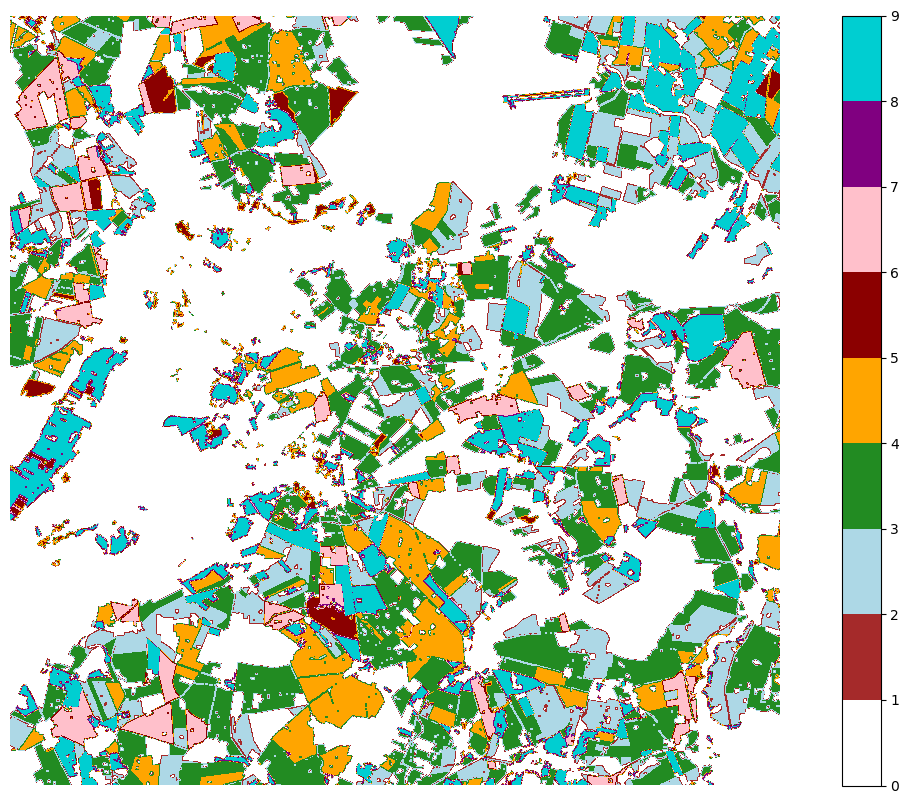

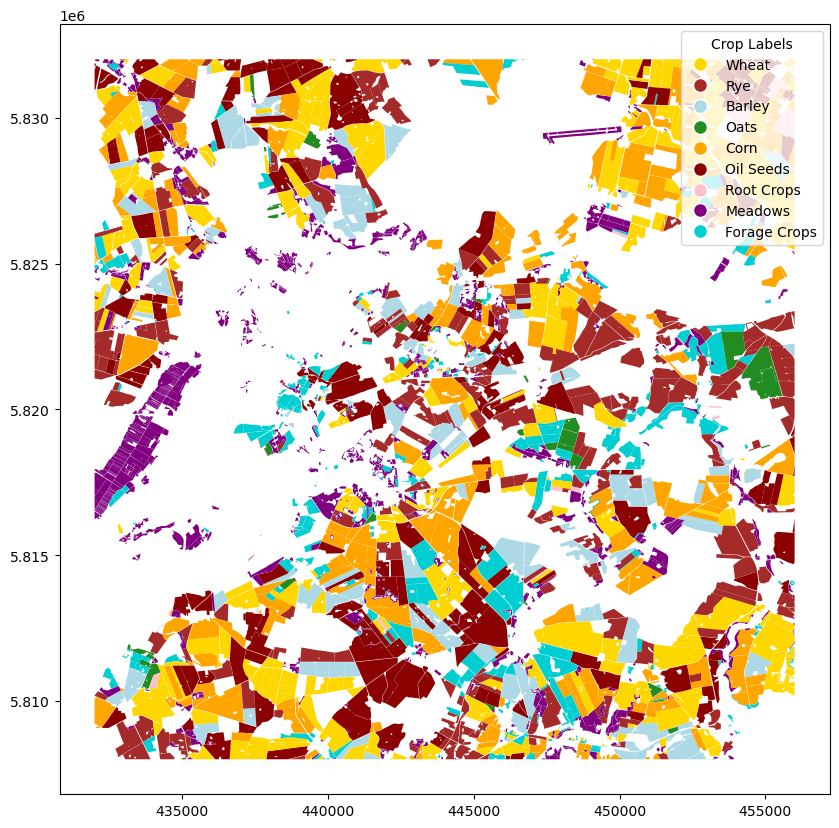

In [22]:
colors = ['#FFFFFF', '#A52A2A', '#ADD8E6', '#228B22', '#FFA500', '#8B0000', '#FFC0CB', '#800080', '#00CED1']
cmap = ListedColormap(colors)
plt.figure(figsize=(16, 10))
plt.imshow(kmeansImage, cmap=cmap)
plt.colorbar()
plt.axis('off')
plt.savefig('s1.png', dpi=300, bbox_inches='tight')
plt.show()

gdf = gpd.read_file(trainingLabels)

# Define colors for each crop label
colors = ['#FFD700', '#A52A2A', '#ADD8E6', '#228B22', '#FFA500', '#8B0000', '#FFC0CB', '#800080', '#00CED1']
# Create a colormap
cmap = ListedColormap(colors)

# Plot the GeoDataFrame with colors based on crop_id
ax = gdf.plot(column='crop_id', cmap=cmap, figsize=(16, 10))

# Map numeric crop IDs to crop labels for legend
legend_labels = {i: label for i, label in enumerate(cropLabels)}

# Create custom legend
handles = [plt.Line2D([0], [0], marker='o', color='w', markersize=10, markerfacecolor=color, label=label) 
           for color, label in zip(colors, cropLabels)]
ax.legend(handles=handles, title='Crop Labels', labels=[legend_labels[i] for i in range(len(cropLabels))])

# Save the plot as PNG
plt.savefig('output_image.png', dpi=300, bbox_inches='tight')

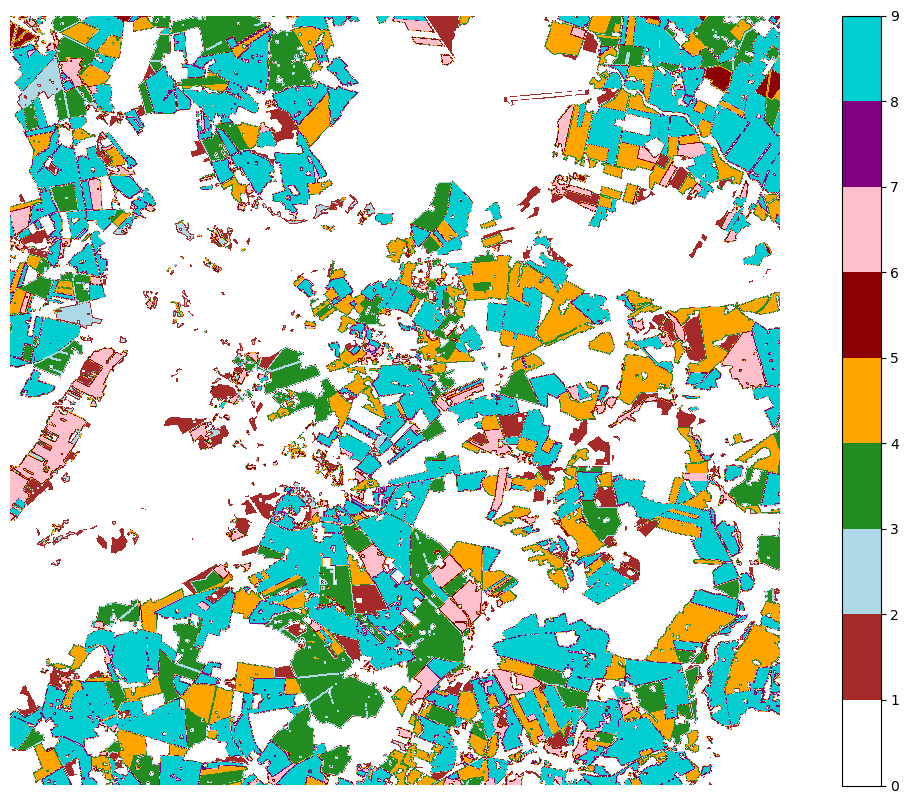

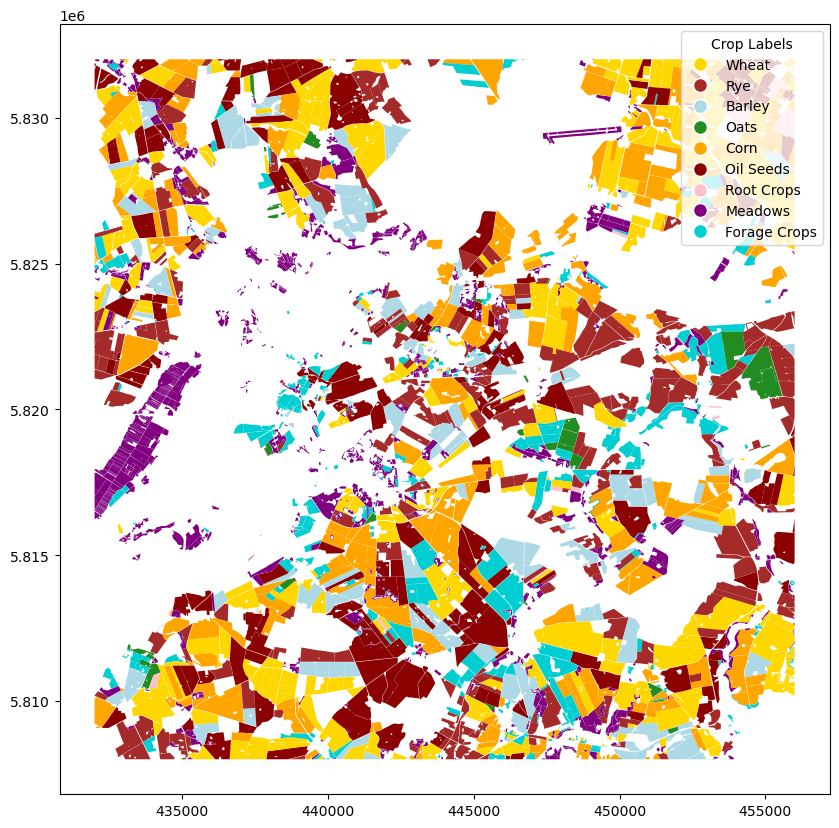

In [23]:
colors = ['#FFFFFF', '#A52A2A', '#ADD8E6', '#228B22', '#FFA500', '#8B0000', '#FFC0CB', '#800080', '#00CED1']
cmap = ListedColormap(colors)
plt.figure(figsize=(16, 10))
plt.imshow(kmeansImage2, cmap=cmap)
plt.colorbar()
plt.axis('off')
plt.show()

gdf = gpd.read_file(trainingLabels)

# Define colors for each crop label
colors = ['#FFD700', '#A52A2A', '#ADD8E6', '#228B22', '#FFA500', '#8B0000', '#FFC0CB', '#800080', '#00CED1']
# Create a colormap
cmap = ListedColormap(colors)

# Plot the GeoDataFrame with colors based on crop_id
ax = gdf.plot(column='crop_id', cmap=cmap, figsize=(16, 10))

# Map numeric crop IDs to crop labels for legend
legend_labels = {i: label for i, label in enumerate(cropLabels)}

# Create custom legend
handles = [plt.Line2D([0], [0], marker='o', color='w', markersize=10, markerfacecolor=color, label=label) 
           for color, label in zip(colors, cropLabels)]
ax.legend(handles=handles, title='Crop Labels', labels=[legend_labels[i] for i in range(len(cropLabels))])

# Save the plot as PNG
plt.savefig('output_image.png', dpi=300, bbox_inches='tight')

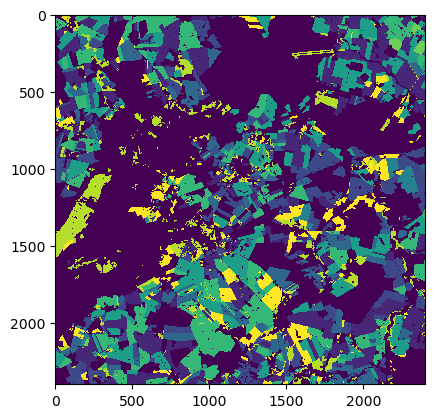

(2400, 2400)


In [24]:
plt.imshow(train_crop_mask, interpolation='nearest')
plt.show()

print(train_crop_mask.shape)

In [25]:
trainingImage = CreateImage(trainingData)

Processing: [=========================================================================================================================] 121/122 (99.2%)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


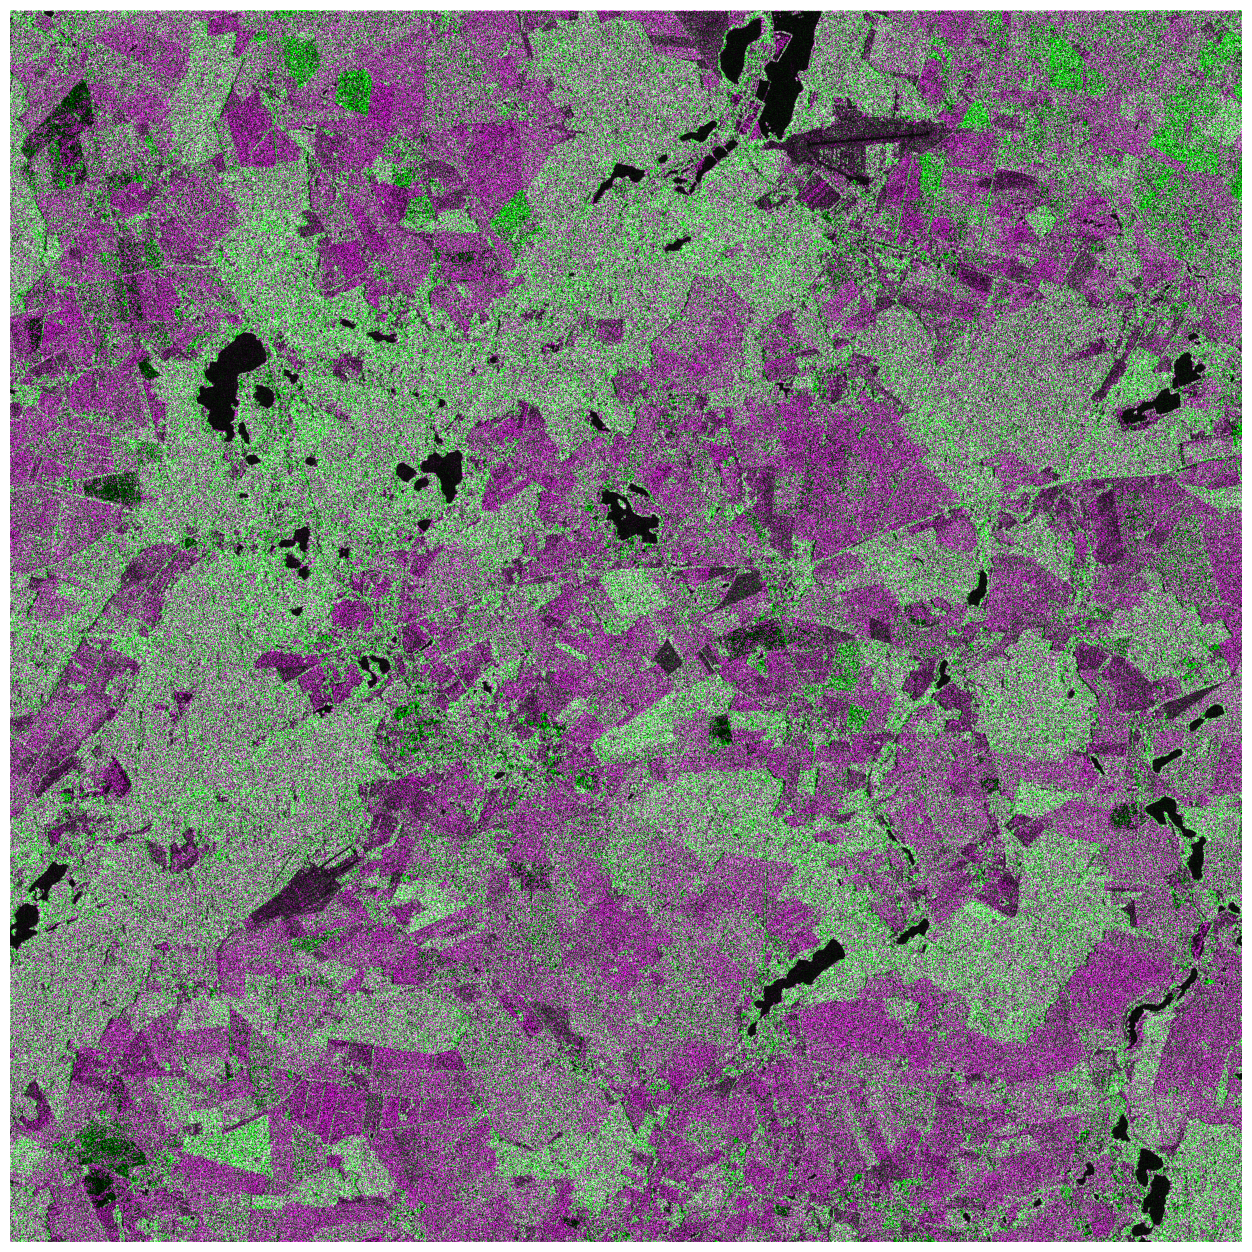

In [26]:
plt.figure(figsize=(24, 16))
plt.imshow(trainingImage[10])
plt.axis('off') 
plt.savefig('dual-pol_Image.png', bbox_inches='tight')
plt.show()

In [27]:
bbox= pd.read_pickle(r"C:\Users\emily\OneDrive - Swansea University\Documents\Proj\sentinel-1\s1-asc-utm-33N-17E-243N-2018\bbox.pkl")
min_x, min_y, max_x, max_y = bbox
width = 2400
height = 2400
transform = rio.transform.from_bounds(min_x, min_y, max_x, max_y, width, height)  # adjust width and height as needed
rio.transform.get_transformer(transform)

count = 2  # Number of bands
dtype = 'float64'
crs = 'EPSG:32633'
with rio.open('output.tif', 'w', driver='GTiff', width=width, height=height, count=count, dtype=dtype, crs=crs, transform=transform) as dst:
    # Write data (assuming a black image in this example)
    for band_index in range(count):
        dst.write(trainingData[0,:, :, band_index], band_index + 1)


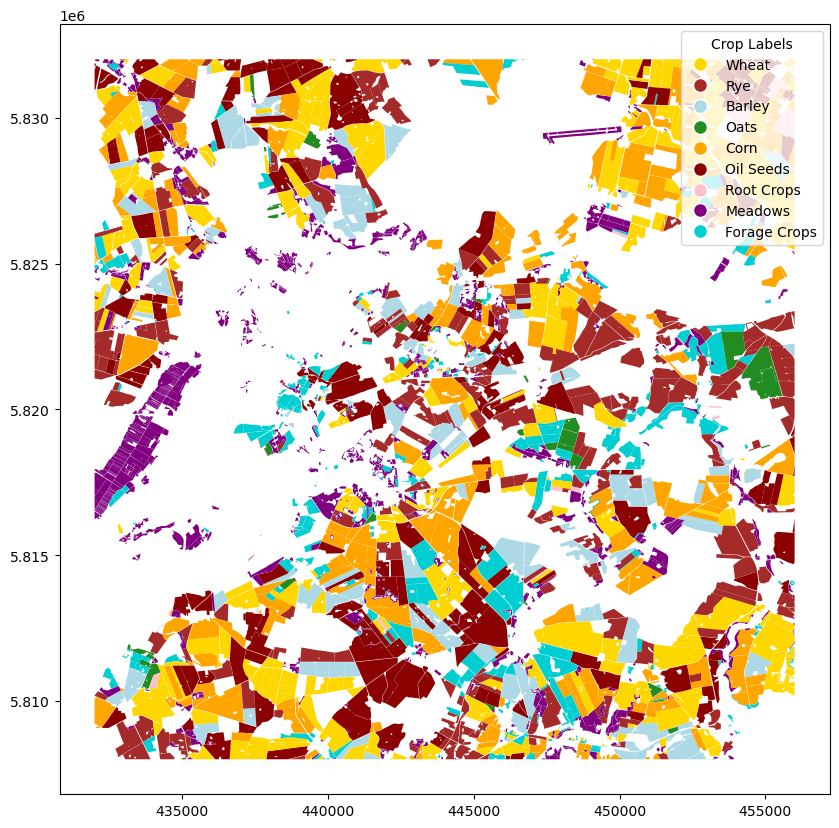

In [28]:
gdf = gpd.read_file(trainingLabels)

# Define colors for each crop label
colors = ['#FFD700', '#A52A2A', '#ADD8E6', '#228B22', '#FFA500', '#8B0000', '#FFC0CB', '#800080', '#00CED1']
# Create a colormap
cmap = ListedColormap(colors)

# Plot the GeoDataFrame with colors based on crop_id
ax = gdf.plot(column='crop_id', cmap=cmap, figsize=(10, 10))

# Map numeric crop IDs to crop labels for legend
legend_labels = {i: label for i, label in enumerate(cropLabels)}

# Create custom legend
handles = [plt.Line2D([0], [0], marker='o', color='w', markersize=10, markerfacecolor=color, label=label) 
           for color, label in zip(colors, cropLabels)]
ax.legend(handles=handles, title='Crop Labels', labels=[legend_labels[i] for i in range(len(cropLabels))])

# Save the plot as PNG
plt.savefig('output_image.png', dpi=300, bbox_inches='tight')